In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sfm.plotstyle import set_seaborn_style, set_style_after

import os

In [2]:
# list all runs in runs/
# Get current notebook path since __file__ isn't defined in notebooks
currentfile = os.path.abspath('')
currentdir = os.path.dirname(currentfile)
runs = os.listdir(f"{currentdir}/runs")
print(runs)

# filter for target distributions
targetdist = "moons"
runs = [run for run in runs if f"-{targetdist}" in run]
print(runs)


['gaussian-moons', 'dirichlet-moons-ot', 'gamma-moons', 'mog-moons', 'diagonal-moons-ot', 'multivariate-moons', 'normal-moons-ot', 'diagonal-moons', 'multivariate-moons-ot', 'dirichlet-moons', '8gaussians-moons', 'uniform-moons-ot', 'gaussian-moons-ot', 'laplace-moons-ot', 'laplace-moons', '8gaussians-moons-ot', 'uniform-moons', 'gamma-moons-ot', 'normal-moons', 'mog-moons-ot']
['gaussian-moons', 'dirichlet-moons-ot', 'gamma-moons', 'mog-moons', 'diagonal-moons-ot', 'multivariate-moons', 'normal-moons-ot', 'diagonal-moons', 'multivariate-moons-ot', 'dirichlet-moons', '8gaussians-moons', 'uniform-moons-ot', 'gaussian-moons-ot', 'laplace-moons-ot', 'laplace-moons', '8gaussians-moons-ot', 'uniform-moons', 'gamma-moons-ot', 'normal-moons', 'mog-moons-ot']


In [3]:
# list files in first run
files = os.listdir(f"{currentdir}/runs/{runs[0]}")
print(files)


['train', 'sidebyside', 'losses.npy', 'mysimplemlp_10000.pth', 'traj_gaussian-to-moons.gif', 'trajectory', 'logprobs_train.npy', 'logprob_gaussian-to-moons_sidebyside.png']


gaussian


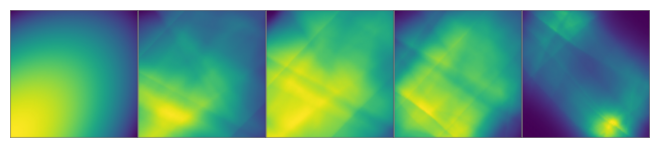

dirichlet OT


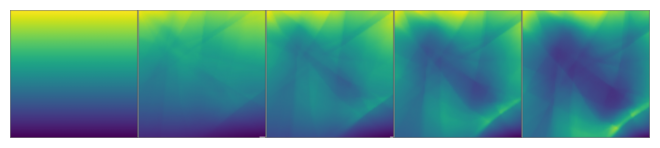

gamma


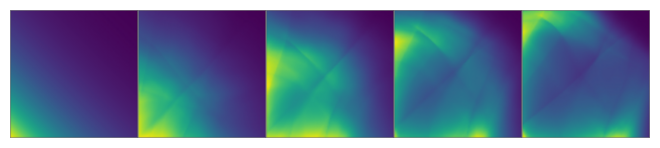

mog


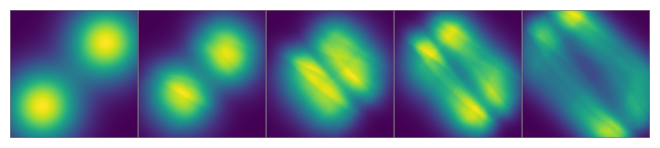

diagonal OT


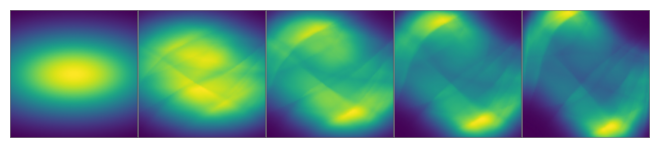

multivariate


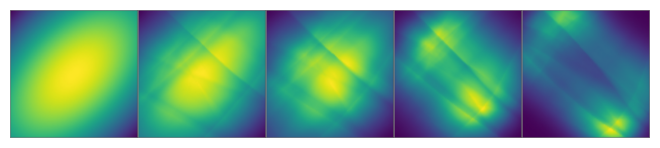

normal OT


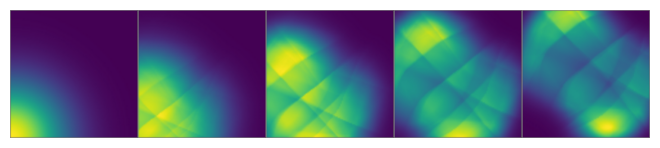

diagonal


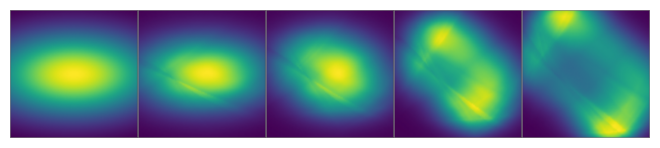

multivariate OT


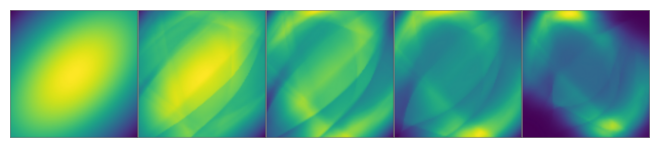

dirichlet


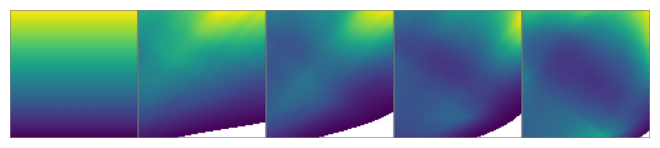

8gaussians


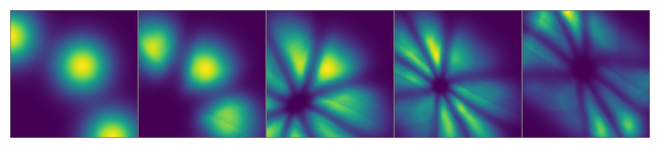

uniform OT


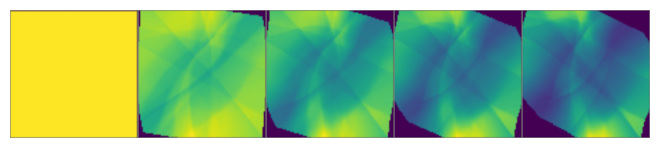

gaussian OT


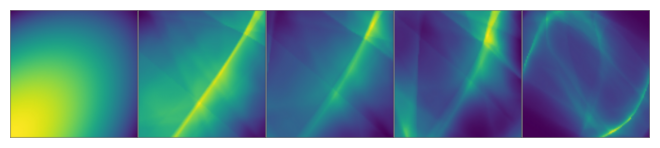

laplace OT


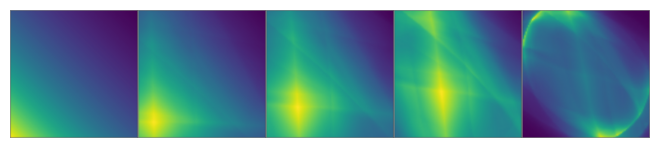

laplace


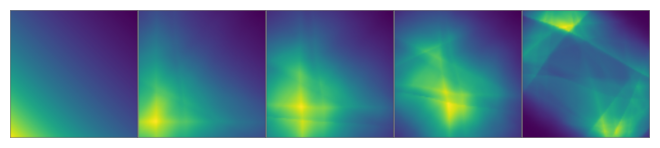

8gaussians OT


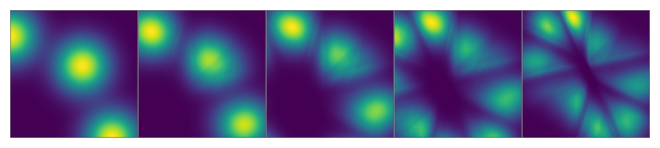

uniform


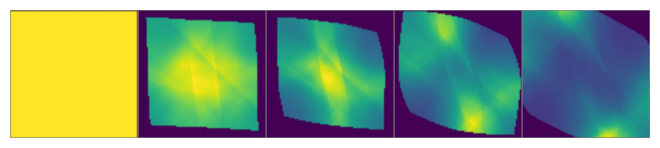

gamma OT


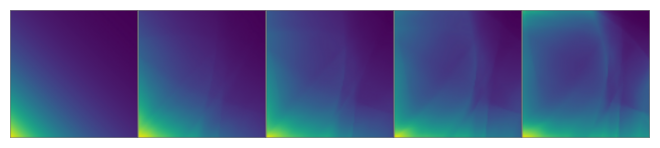

normal


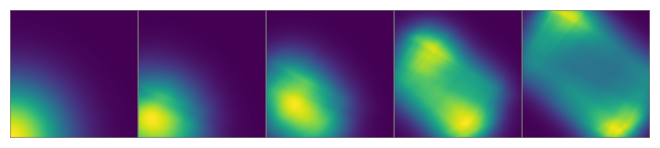

mog OT


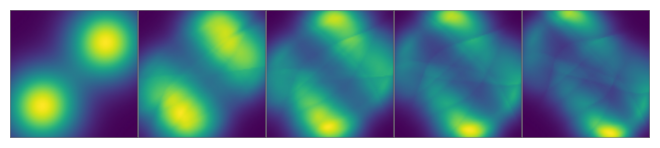

In [4]:
# for every run, show logprob_<src>-to-<trgt>_sidebyside.png
for run in runs:
    src = run.split("-")[0]
    trgt = run.split("-")[1]  
    runname = src
    if "-ot" in run:
        runname += " OT"
    print(runname)
    plt.imshow(plt.imread(f"{currentdir}/runs/{run}/logprob_{src}-to-{trgt}_sidebyside.png"))
    # remove axes
    plt.axis('off')
    # remove ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.tight_layout(pad=0)
    plt.show()


In [5]:
# get logprobs_train.npy and losses.npy for every run into a dict
logprobs_train = {}
losses = {}
for run in runs:
    logprobs_train[run] = np.load(f"{currentdir}/runs/{run}/logprobs_train.npy")
    losses[run] = np.load(f"{currentdir}/runs/{run}/losses.npy")


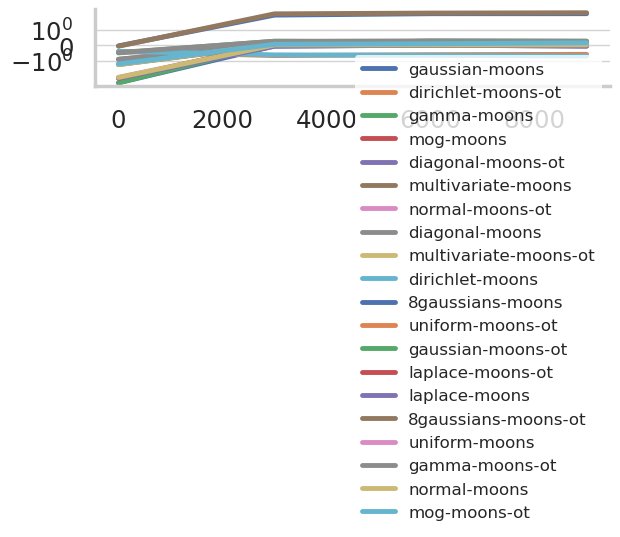

In [6]:
# plot logprobs_train.npy for every run
set_seaborn_style()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_yscale("symlog")
for run in runs:
    # first column is x, second column is y
    ax.plot(logprobs_train[run][:, 0], logprobs_train[run][:, 1], label=run)
# y log scale
set_style_after(ax, legend=True, loc="upper right", bbox_to_anchor=(1.0, .51), fs=12)
plt.show()
plt.close()

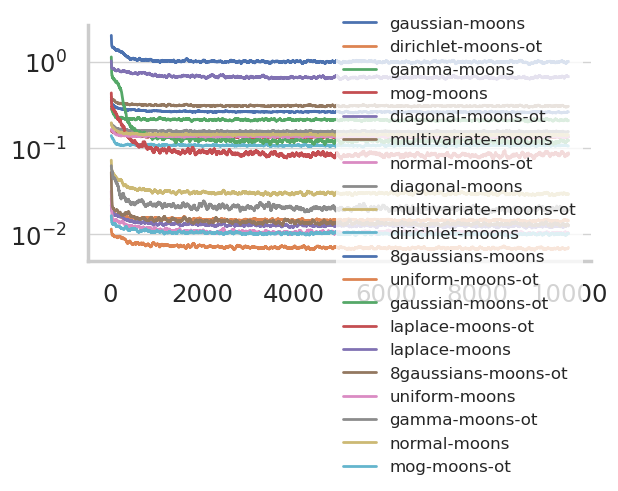

In [7]:
# plot losses.npy for every run
# apply smoothing to losses.npy
losses_smooth = {}
# first column is x=step, second column is y=loss
window_size = 51  # Use odd number to ensure equal padding on both sides
for run in runs:
    # Apply smoothing separately to x and y columns
    x = losses[run][:, 0]  # time steps
    y = losses[run][:, 1]  # loss values
    # Smooth only the y values
    y_smooth = np.convolve(y, np.ones(window_size)/window_size, mode='valid')
    # Trim x and y_smooth to same length
    trim = (window_size - 1) // 2
    x = x[trim:-trim]
    # Verify lengths match
    assert len(x) == len(y_smooth), f"Length mismatch: x={len(x)}, y_smooth={len(y_smooth)}"
    # Recombine into array
    losses_smooth[run] = np.column_stack((x, y_smooth))

# subsample, only plot every n'th point
n = 1
losses_smooth = {run: losses_smooth[run][::n, :] for run in runs}

set_seaborn_style()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_yscale("log")
for run in runs:
    ax.plot(
        losses_smooth[run][:, 0], losses_smooth[run][:, 1], label=run, linewidth=2
    )
set_style_after(ax, legend=True, loc="upper right", bbox_to_anchor=(1.0, 1.1), fs=12)
plt.show()
plt.close()

gaussian-moons 1.0


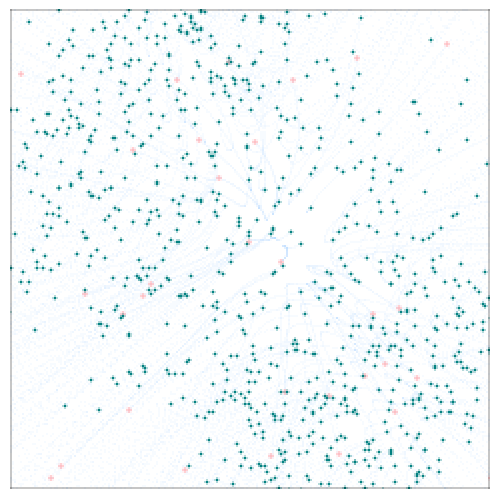

dirichlet-moons-ot 1.0


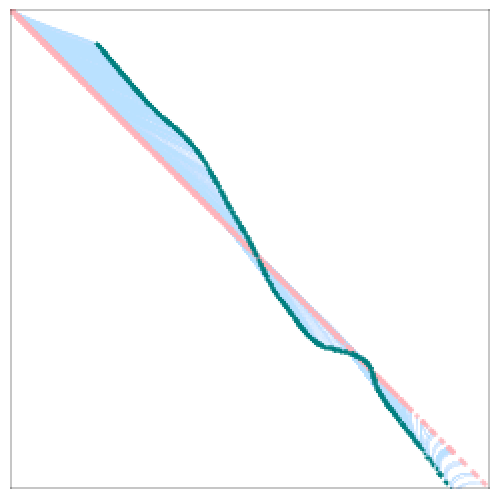

gamma-moons 1.0


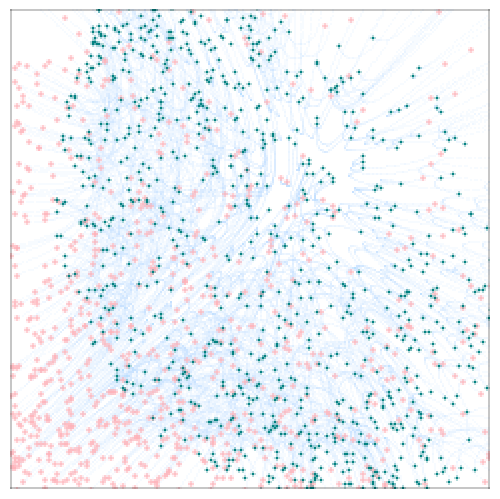

mog-moons 1.0


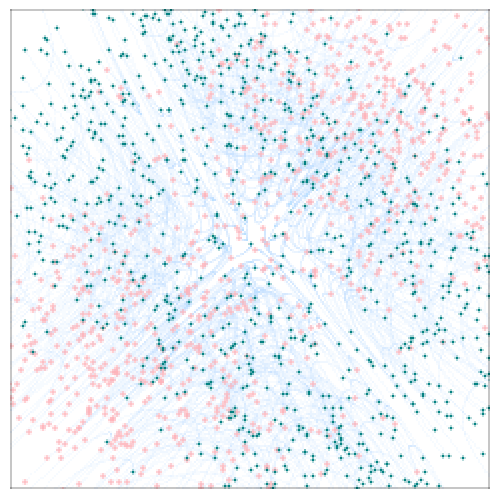

diagonal-moons-ot 1.0


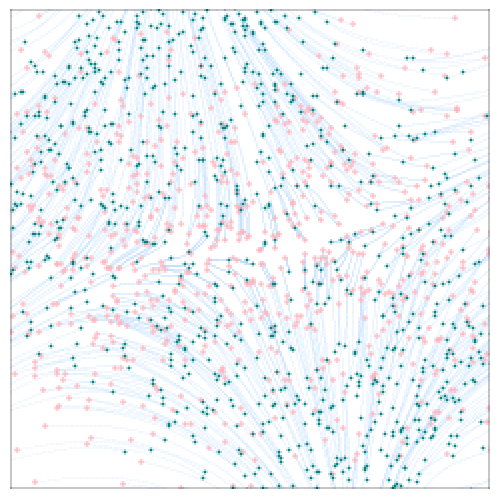

multivariate-moons 1.0


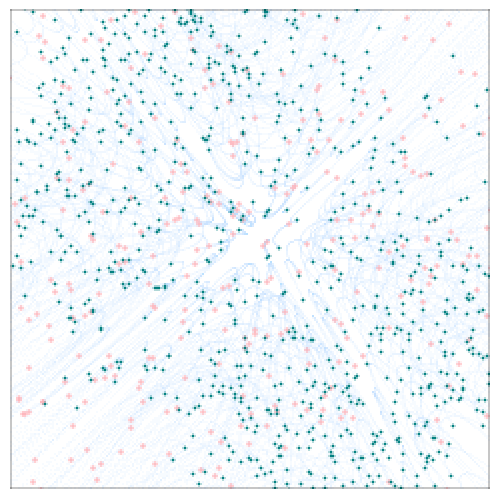

normal-moons-ot 1.0


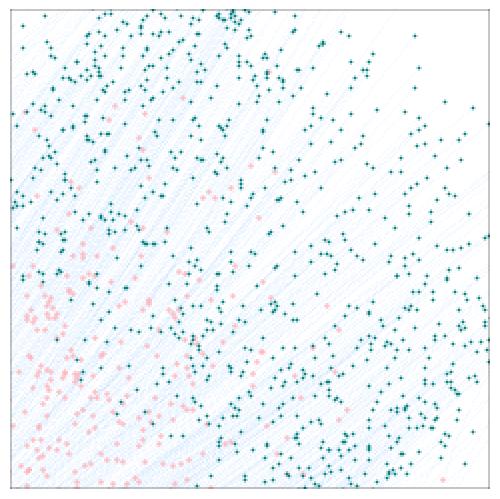

diagonal-moons 1.0


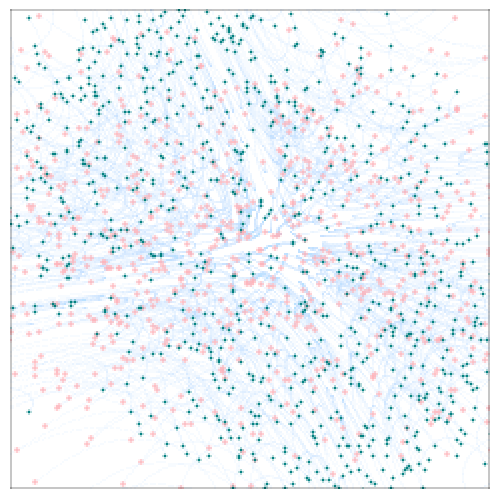

multivariate-moons-ot 1.0


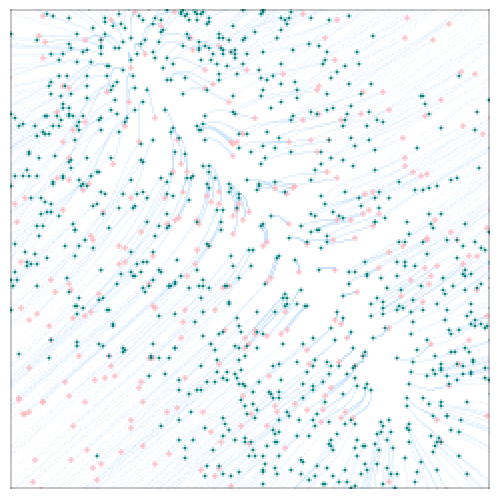

dirichlet-moons 1.0


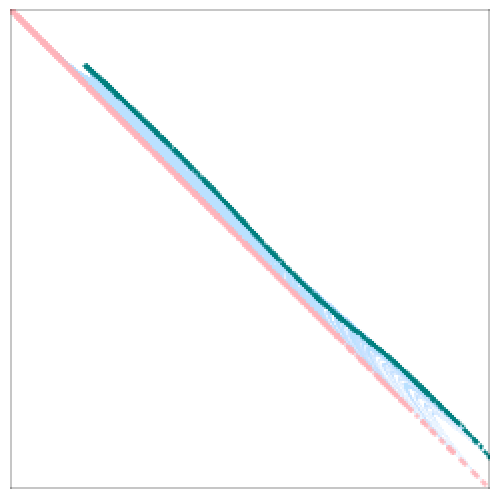

8gaussians-moons 1.0


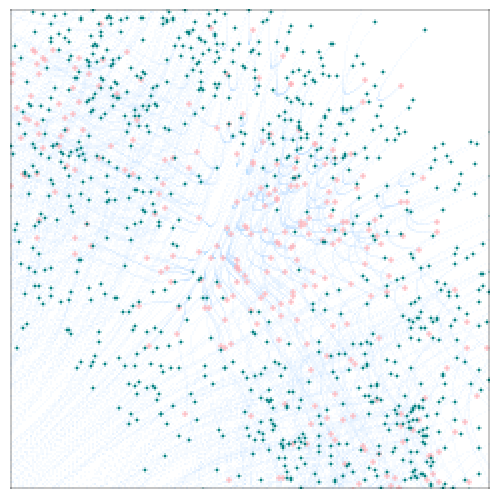

uniform-moons-ot 1.0


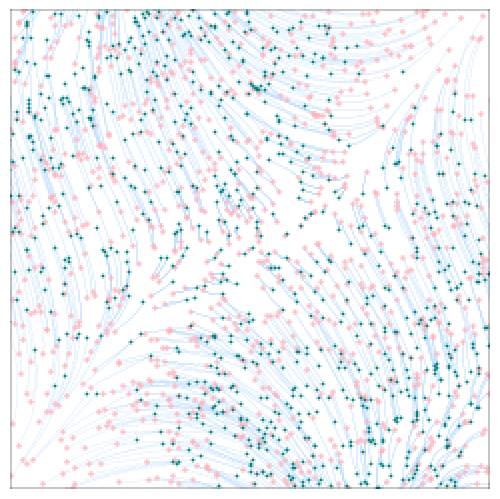

gaussian-moons-ot 1.0


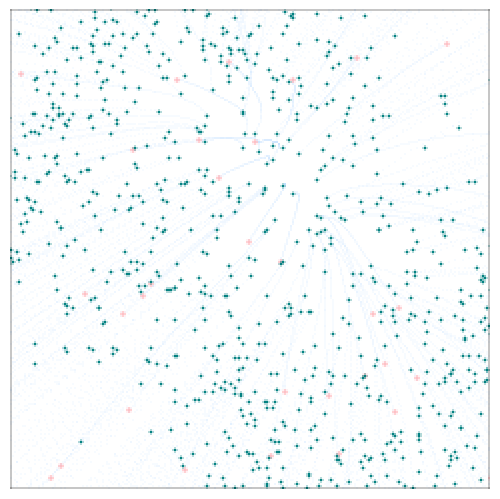

laplace-moons-ot 1.0


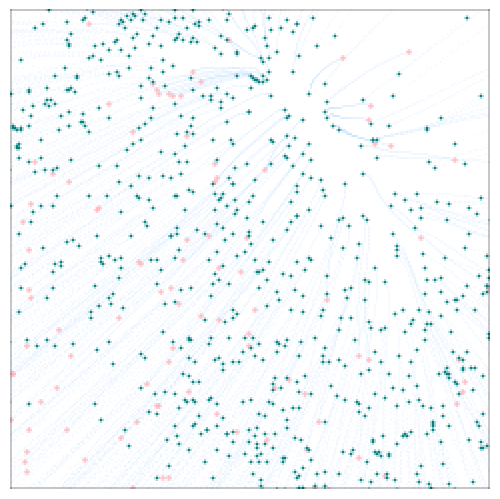

laplace-moons 1.0


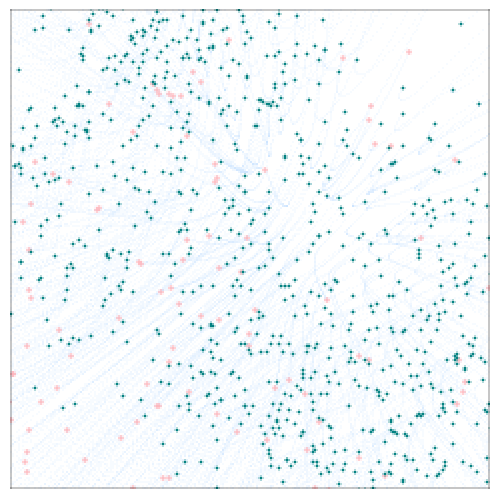

8gaussians-moons-ot 1.0


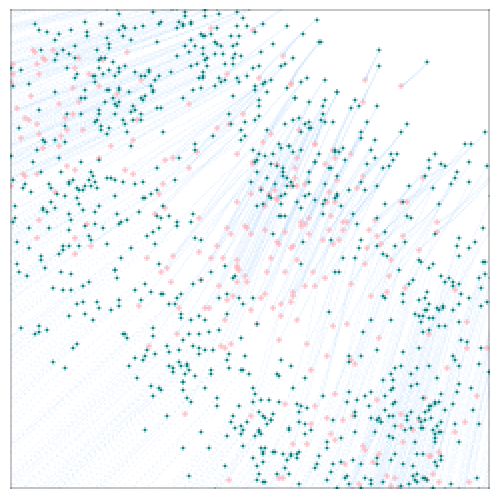

uniform-moons 1.0


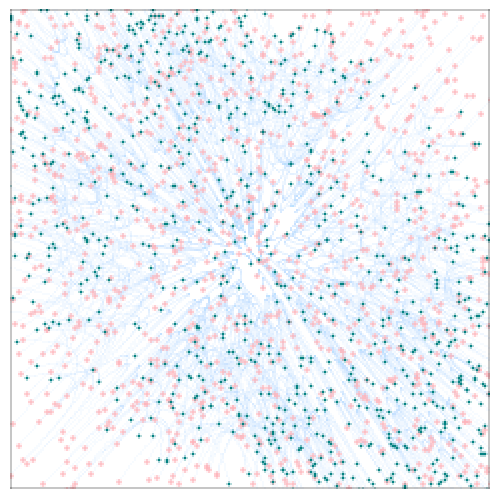

gamma-moons-ot 1.0


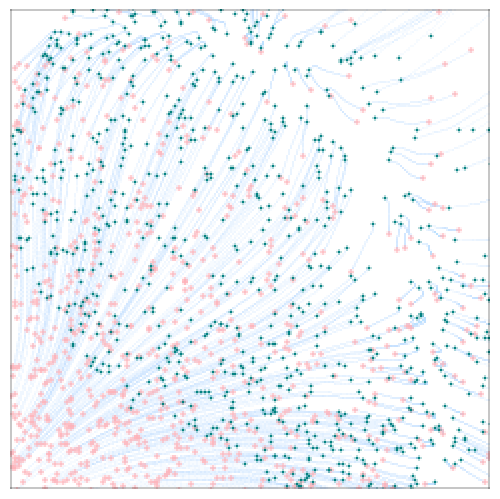

normal-moons 1.0


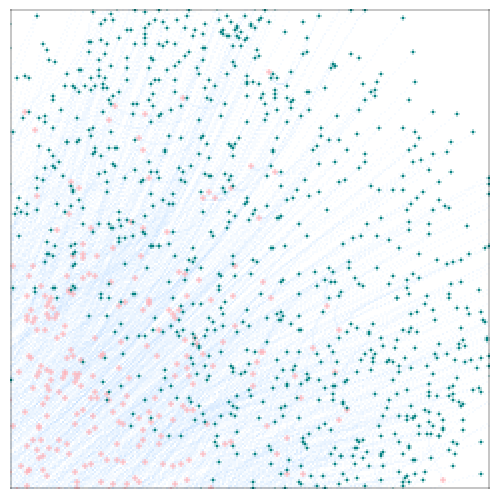

mog-moons-ot 1.0


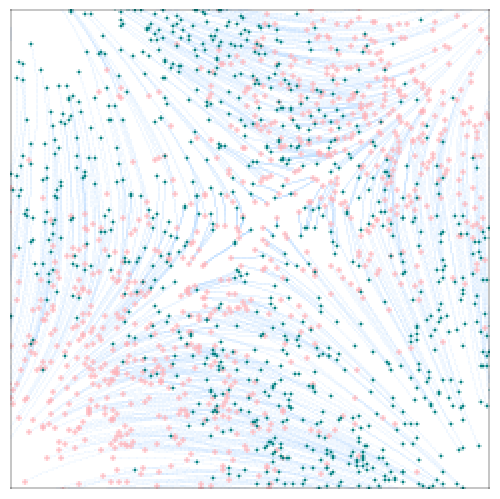

In [9]:
# plot the latest file in runs/<run>/trajectory/

for run in runs:
    _files = os.listdir(f"{currentdir}/runs/{run}/trajectory/")
    # time is in format _0.92.png
    _times = [float(file.split("_")[-1].split(".")[0]) for file in _files]
    latest_file = _files[_times.index(max(_times))]
    print(run, max(_times))
    
    plt.imshow(plt.imread(f"{currentdir}/runs/{run}/trajectory/{latest_file}"))
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    plt.close()